In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy.stats as stats
import statsmodels.api as sm

# Importing the Time Series Analysis module for simulating data
import pmdarima as pm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

from arch import arch_model
from arch.univariate import ARX
from arch.univariate import GARCH

# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (7,5)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pmdarima
!pip install arch

In [179]:
def KPSS(timeseries):
    test = kpss(timeseries)
    print('KPSS Statistic: %f' % test[0])
    print('p-value: %f' % test[1])
    print('Critical Values:')
    for item, value in test[3].items():
        print('\t%s: %.2f' % (item, value))
    
    
def AdFuller(timeseries):
    test = adfuller(timeseries)
    print('ADF Statistic: %f' % test[0])
    print('p-value: %f' % test[1])
    print('Critical Values:i/')
    for item, value in test[4].items():
        print('\t%s: %.2f' % (item, value))
        
def plot_diagnosticsTight3(data,df=0):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True,auto_ylims=True)
    ax3.grid()

    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,model_df=df)#package version

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()
    ax5.set_title('QQ plot Normal')

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()
    
def plot_diagnosticsTight3_t(data, df_lj =0, df_t = 1): #df_lj and df_t are dof's for ljung-box test and t_distribution

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    n = len(x)
    ax1.plot(x, stats.t.pdf(x, n - 1), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True,auto_ylims=True)
    ax3.grid()

    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data, model_df=df_lj)     #package version

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, stats.t ,fit=True,line='q', ax = ax5)
    ax5.grid()
    ax5.set_title("QQ plot T-dist")

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()

# Question 1 

## Read and Clean data

In [203]:
TB3MS = (
    pd.read_csv('data/TB3MS.csv')
    .set_index('DATE')
    .dropna()
)

In [204]:
TB3MS.head(3)

,TB3MS
DATE,
2000-01-01,5.32
2000-02-01,5.55
2000-03-01,5.69


## Analyze the Timeseries

Text(0.5, 1.0, '3-Month Treasury Bill Rates')

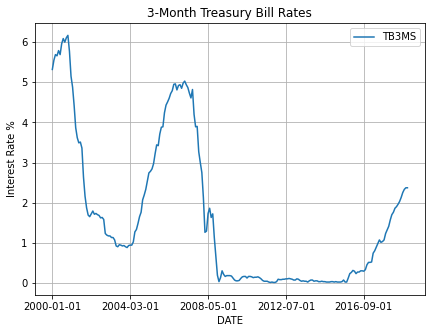

In [205]:
TB3MS.plot()
plt.ylabel('Interest Rate %')
plt.grid()
plt.title('3-Month Treasury Bill Rates')

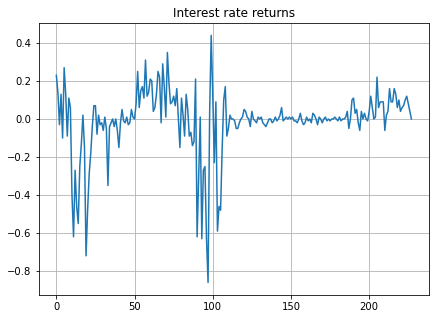

In [206]:
diff = np.diff(TB3MS['TB3MS'])
plt.plot(diff)
plt.title('Interest rate returns')
plt.grid(); plt.show()


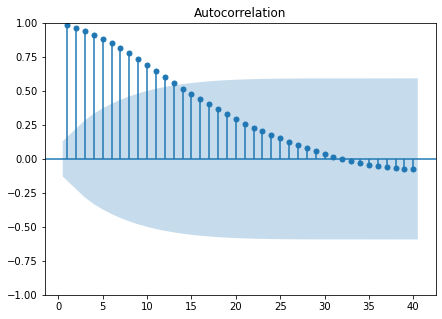

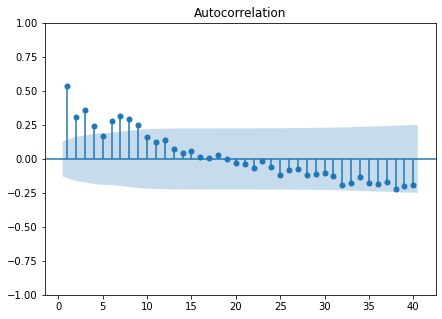

In [207]:
# Autocorrelation tests
plot_acf(TB3MS['TB3MS'],zero = False, lags = 40);
plot_acf(diff, zero = False, lags =40);
plt.show()

In [208]:
# Does not pass stationary tests, can't use ARMA model
KPSS(diff)
AdFuller(diff)

KPSS Statistic: 0.275596
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74
ADF Statistic: -2.668589
p-value: 0.079633
Critical Values:i/
	1%: -3.46
	5%: -2.87
	10%: -2.57


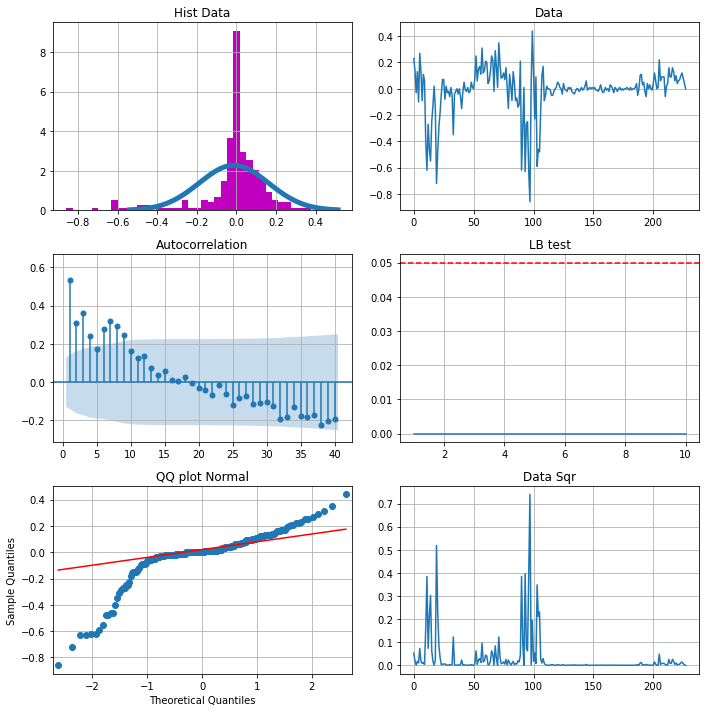

In [209]:
plot_diagnosticsTight3(diff,df=0)

## Clearly heteroskedastic data, apply GARCH-ARMA model 

In [210]:
?pm.auto_arima

In [211]:
# Find optimal model for the mean 
results = pm.auto_arima(diff, trace = True, seasonal=False,
                        stationary = True, stepwise = False,with_intercept=True,
                        information_criterion='aic', start_q=0, max_p = 6, max_q = 1, d = 0)
# Order selected is given in summary
print(results.summary())

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-142.435, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-209.527, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-217.715, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-217.287, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-215.993, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-216.649, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-229.264, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-228.375, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-228.427, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-226.496, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-226.831, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.427 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(3, 0, 0)  

In [212]:
#from arch.univariate import ARX
arx = ARX(diff, lags= 3,rescale = False) #this is equal to AR(3) as per above
arx.volatility = GARCH(2,0,1) # Optimal GARCH model 
AR_GARCH = arx.fit(update_freq=0)#, tol=0.000001
print(AR_GARCH.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -242.75015890860067
            Iterations: 29
            Function evaluations: 301
            Gradient evaluations: 27
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.329
Mean Model:                        AR   Adj. R-squared:                  0.320
Vol Model:                      GARCH   Log-Likelihood:                242.750
Distribution:                  Normal   AIC:                          -469.500
Method:            Maximum Likelihood   BIC:                          -442.172
                                        No. Observations:                  225
Date:                Tue, Dec 05 2023   Df Residuals:                      221
Time:                        21:40:01   Df Model:                            4
                                  Mean Model                                 

In [213]:
# Check if rescaling improves model - rescale = FALSE is clearly better 
arx = ARX(diff, lags= 3,rescale = True) #this is equal to AR(3) as per above
arx.volatility = GARCH(2,0,1)
AR_GARCH_scaled = arx.fit(update_freq=0)#, tol=0.000001
print(AR_GARCH_scaled.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 275.33148725059544
            Iterations: 17
            Function evaluations: 172
            Gradient evaluations: 17
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.329
Mean Model:                        AR   Adj. R-squared:                  0.320
Vol Model:                      GARCH   Log-Likelihood:               -275.331
Distribution:                  Normal   AIC:                           566.663
Method:            Maximum Likelihood   BIC:                           593.992
                                        No. Observations:                  225
Date:                Tue, Dec 05 2023   Df Residuals:                      221
Time:                        21:40:01   Df Model:                            4
                                  Mean Model                                 


## Check model and residual Diagnostics

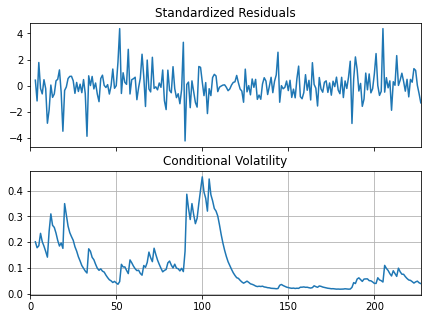

In [214]:
# Exploring the outputs
AR_GARCH.plot()
plt.grid()
plt.show()

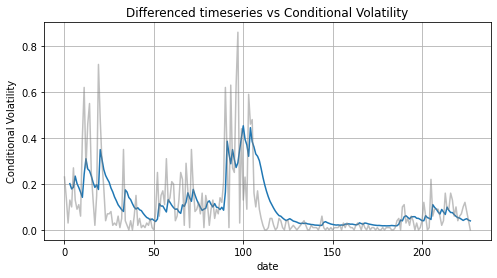

In [215]:
# Plot conditional vol vs abs(ret)
plt.figure(1, figsize=(8,4))
plt.plot(AR_GARCH.conditional_volatility)
plt.plot(abs(diff), color = 'grey', alpha = 0.5)
plt.xlabel('date'); plt.ylabel('Conditional Volatility')
plt.title('Differenced timeseries vs Conditional Volatility')
plt.grid(); plt.show()

Check standardized residuals to check performance of volatility modeling 

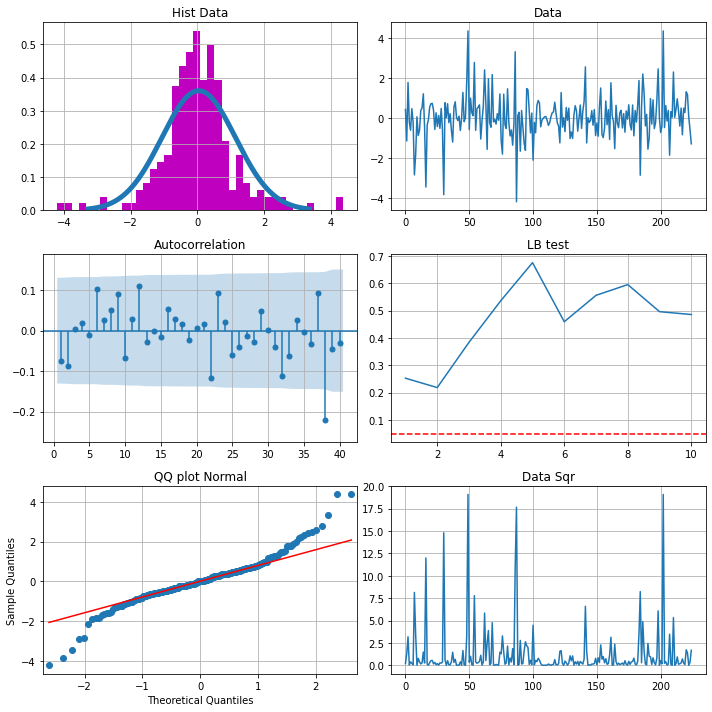

In [216]:
std_resid = AR_GARCH.resid/AR_GARCH.conditional_volatility
std_resid = std_resid[~np.isnan(std_resid)]
plot_diagnosticsTight3(std_resid)

LJung-box test has been passed but data does still not appear to be completely normal, so perform normality tests:

* Jargue Bera confirms normality 
* Shapiro test rejects normality 

A different distribution could be considered

In [217]:
# normality tests 
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Jarque-Bera statitiscs:  102.52280423778372
Jarque-Bera p-value:  0.0
Shapiro statitiscs:  0.9411949515342712
Shapiro p-value:  7.035134075294991e-08


Test possibility of using t-distribution for our AR_GARCH model. This should model tails better

In [218]:
from arch.univariate import StudentsT

arx_T = ARX(diff, lags = 3, rescale = False)
arx_T.volatility=GARCH(2,0,1)
arx_T.distribution=StudentsT()

AR_GARCH_T = arx_T.fit()
print(AR_GARCH_T.summary())

Iteration:      1,   Func. Count:     11,   Neg. LLF: 9511.454264667565
Iteration:      2,   Func. Count:     31,   Neg. LLF: 3865.3322307069766
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2472.2260660910833
Iteration:      4,   Func. Count:     56,   Neg. LLF: 430.88789682821664
Iteration:      5,   Func. Count:     67,   Neg. LLF: 936.7079090198308
Iteration:      6,   Func. Count:     81,   Neg. LLF: 925.5070516010703
Iteration:      7,   Func. Count:     96,   Neg. LLF: 14826.321412939822
Iteration:      8,   Func. Count:    107,   Neg. LLF: -116.57517877016139
Iteration:      9,   Func. Count:    118,   Neg. LLF: -22.0862445595872
Iteration:     10,   Func. Count:    129,   Neg. LLF: -39.10099177560145
Iteration:     11,   Func. Count:    140,   Neg. LLF: -47.878882052486745
Iteration:     12,   Func. Count:    151,   Neg. LLF: -60.58555899165552
Iteration:     13,   Func. Count:    162,   Neg. LLF: -233.85530793977048
Iteration:     14,   Func. Count:    173,   Neg. LLF

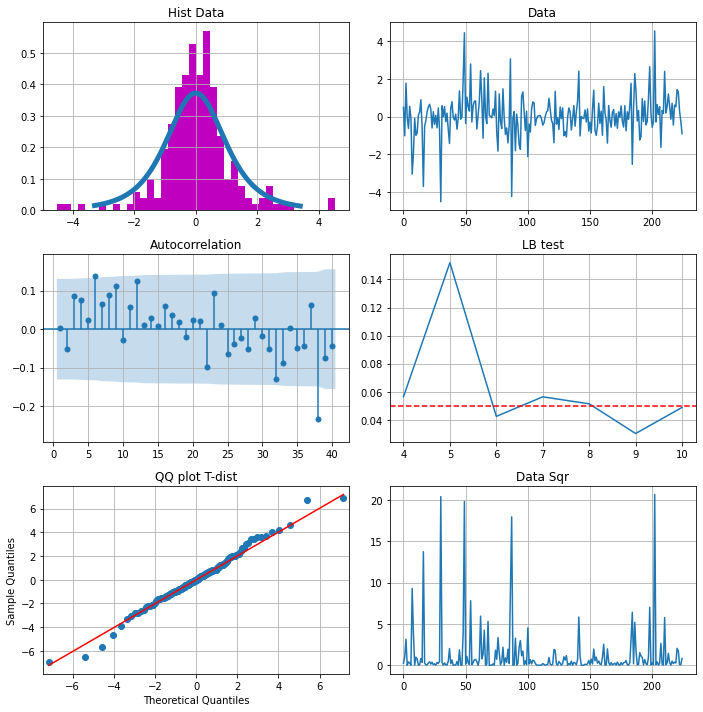

In [219]:
std_resid = AR_GARCH_T.resid/AR_GARCH_T.conditional_volatility
std_resid = std_resid[~np.isnan(std_resid)]

# plot diagnostics for student t-distribution
plot_diagnosticsTight3_t(std_resid, 3, 3.6)

qqplot has severely improved and using students t distribution was clearly a good choice. 

# Question 2

## Data

In [220]:
df = (
    pd.read_pickle('data/WheatExportData.pkl')
    .dropna()
    .rename(columns = {'Exports ' : 'Exports'})
)
df.head()

,Exports
Date,
01/04/1990,519188
01/11/1990,560467
01/18/1990,659829
01/25/1990,619135
02/01/1990,677870


<AxesSubplot:xlabel='Date'>

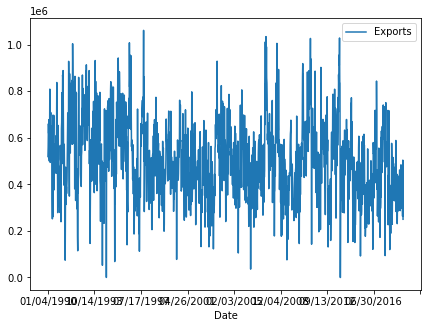

In [221]:
# remove potential outliers -  standard deviations outside of mean
z_scores = stats.zscore(df)
df = df[(z_scores < 3.5) & (z_scores > -3.5)].dropna()
df.plot()

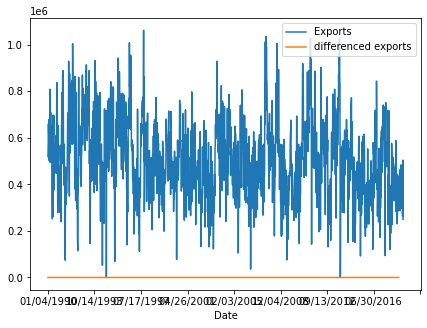

In [222]:
df_diff = np.log(df['Exports']).diff().dropna()
df_diff = df_diff[~np.isnan(df_diff)]

# plot 
df.plot()
plt.plot(df_diff, label = 'differenced exports')
plt.legend()

mean and volatility of data seem somewhat stationary and homoskedastic at first sight, but clear seasonality. 

In [223]:
# normalize data 
df_diff = (df_diff - df_diff.mean())/ df_diff.std()

### Test for stationarity 

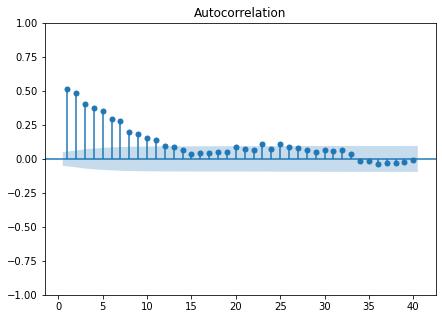

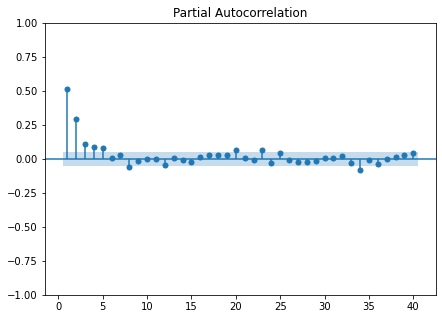

In [224]:
# Autocorrelation tests
plot_acf(df['Exports'],zero = False, lags = 40);
plot_pacf(df['Exports'], zero = False, lags = 40);
plt.show()

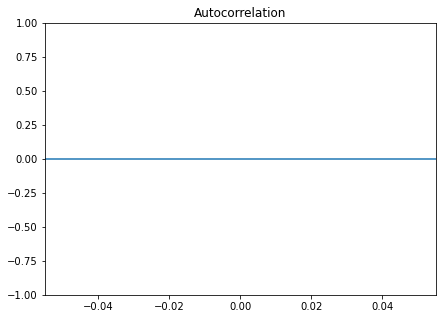

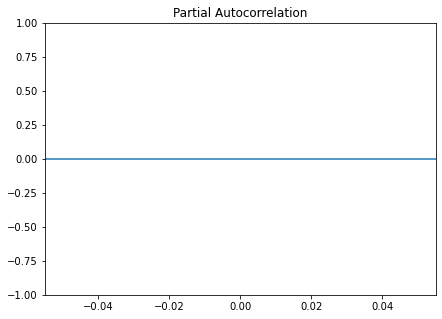

In [225]:
# Autocorrelation for differenced data
plot_acf(df_diff, zero = False, lags = 40)
plot_pacf(df_diff, zero = False, lags = 40)
plt.show()

In [226]:
# Stationarity tests 
KPSS(df_diff)
AdFuller(df_diff)

ValueError: cannot convert float NaN to integer

The KPSS and Adfuller tests tell us that we have stationary data. Lets try and model the seasonality of the model + mean + volatility

### Discover Seasonality 

In [227]:
season = seasonal_decompose(df_diff, model = 'additive', period = 52)
season.plot()
plt.show()

ValueError: This function does not handle missing values

### Model selection

In [228]:
?pm.auto_arima

In [58]:
# Find optimal AR() model for the mean 
results = pm.auto_arima(df_diff, trace = True, seasonal= False,
                        stationary = True, stepwise = False, with_intercept=True,
                        information_criterion='aic', start_q=0, max_p = 6, max_q = 0, d = 0, max_P = 6, max_Q = 6)

# Order selected is given in summary
print(results.summary())

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4334.600, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3970.323, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3899.806, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3858.846, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3830.192, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3826.714, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 0.346 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1526
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1906.357
Date:                Wed, 29 Nov 2023   AIC                           3826.714
Time:                        15:52:17   BIC                           3864.027
Sample:                             0   HQIC                          3840.603
                               - 1526                

In [59]:
## add regressor to model seasonality of the mean 

count = 0
cosine = np.zeros(len(df_diff)); sine = np.zeros(len(df_diff))

for i in df_diff:
    cosine[count] = np.cos((2*np.pi*i)/52)
    sine[count] = np.sin((2*np.pi* i)/52)
    count += 1
    
# create pandas dataframe with regressors 
exog = pd.DataFrame()
exog['cosine'] = cosine
exog['sine'] = sine

In [60]:
arx = ARX(df_diff, x = exog, lags= 5, rescale = False) #this is eq. to AR(5) as per above, but with external regressors
sinusoidal = arx.fit(update_freq=0)
print(sinusoidal.summary())

                    AR-X - Constant Variance Model Results                    
Dep. Variable:                      y   R-squared:                       1.000
Mean Model:                      AR-X   Adj. R-squared:                  1.000
Vol Model:          Constant Variance   Log-Likelihood:                4907.69
Distribution:                  Normal   AIC:                          -9797.37
Method:            Maximum Likelihood   BIC:                          -9749.43
                                        No. Observations:                 1521
Date:                Wed, Nov 29 2023   Df Residuals:                     1513
Time:                        15:52:18   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const          -0.2728      0.192     -1.423      0.

As we can see, performance of the model improved significantly through the use of external seasonality features

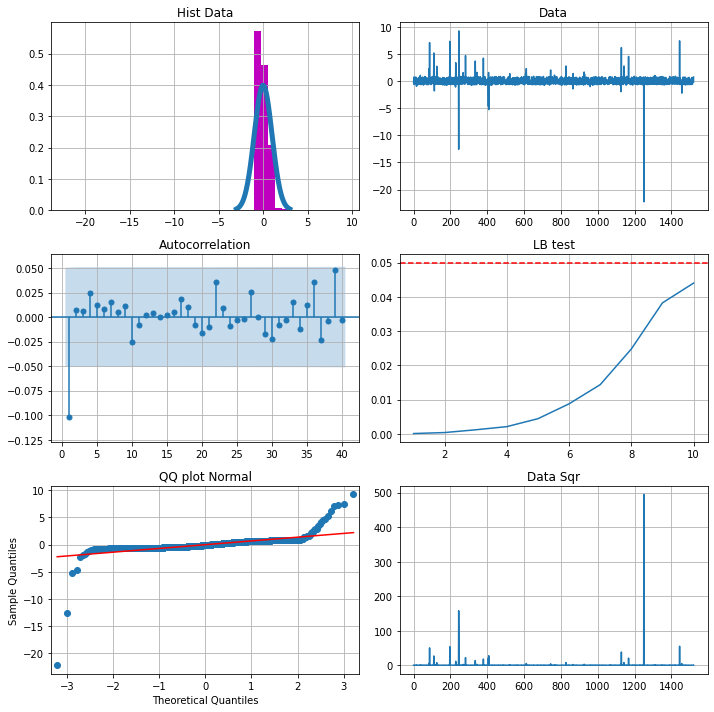

In [61]:
std_resid = sinusoidal.resid/sinusoidal.conditional_volatility
std_resid = std_resid[~np.isnan(std_resid)]

# plot diagnostics
plot_diagnosticsTight3(std_resid)

In [62]:
## add on volatility modelling 
arx = ARX(df_diff, x = exog, lags= 5, rescale = False) #this is eq. to AR(5)
arx.volatility = GARCH(4,0,1)
sinusoidal_vol = arx.fit(update_freq=0)
print(sinusoidal_vol.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4925.578447136199
            Iterations: 45
            Function evaluations: 903
            Gradient evaluations: 42
                          AR-X - GARCH Model Results                          
Dep. Variable:                      y   R-squared:                       1.000
Mean Model:                      AR-X   Adj. R-squared:                  1.000
Vol Model:                      GARCH   Log-Likelihood:                4925.58
Distribution:                  Normal   AIC:                          -9823.16
Method:            Maximum Likelihood   BIC:                          -9748.58
                                        No. Observations:                 1521
Date:                Wed, Nov 29 2023   Df Residuals:                     1513
Time:                        15:52:18   Df Model:                            8
                                  Mean Model                                  

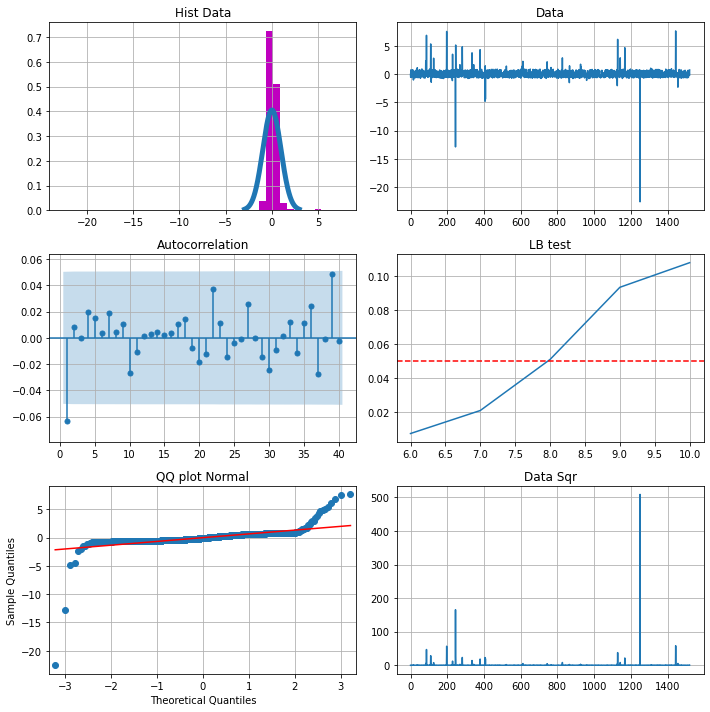

In [189]:
std_resid = sinusoidal_vol.resid/sinusoidal_vol.conditional_volatility
std_resid = std_resid[~np.isnan(std_resid)]

# plot diagnostics
plot_diagnosticsTight3(std_resid, 5)

We are close to passing the residuals as white noise, however the distribution still seems to have strong outliers. We test for normality. 

In [64]:
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

Jarque-Bera statitiscs:  2751867.7368901637
Jarque-Bera p-value:  0.0


In [65]:
shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Shapiro statitiscs:  0.48780518770217896
Shapiro p-value:  0.0


Both tests reject hypothesis for normality. Student T distribution doesn't work however, could consider alternative tests.

Could also consider using exponentially weighted moving average to avoid massive outliers on differenced data. 

# Question 3

 Load the ‘USDJPYVolATM.csv’ file by importing the pandas library ‘import pandas as pd’ and by using the command
df_vol = pd.read_csv (‘USDJPYVolATM.csv’)
1
This will return the data to a dataframe df_vol. This data contains
daily at-the-money (ATM) volatility level expressed in % of the USDJPY FX rate for various expiries. Plot the volatility term structure for
the dates ‘2016-01-04’, ‘2017-12-04’ and ‘2018-12-31’. Analyse the correlation between the changes in volatility of various expiries and propose
a principal component analysis for capturing the moves of the volatility
term-structure curve.

In [107]:
df_vol = pd.read_csv('data/USDJPYVolATM.csv').set_index('Date')
#df_vol = pd.to_datetime(df_vol['Date'])
#df_vol = df_vol.set_index('Date')
df_vol.head(4)

,2W,1M,3M,6M,1Y,2Y,5Y
Date,,,,,,,
10/11/2020,6.690,6.5250,6.5175,6.5975,6.7350,6.8500,7.030
09/11/2020,6.870,6.6950,6.6025,6.6925,6.8500,6.9775,7.080
06/11/2020,6.925,6.6550,6.8025,6.9525,7.0875,7.1350,7.165
05/11/2020,7.030,6.5775,6.7300,6.8575,7.0475,7.1275,7.205


Text(0.5, 1.0, 'ATM volatility in % of USDJPY FX')

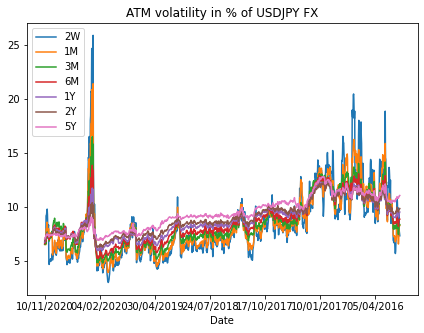

In [166]:
df_vol.plot()
plt.title('ATM volatility in % of USDJPY FX')

## Plot volatility term structure

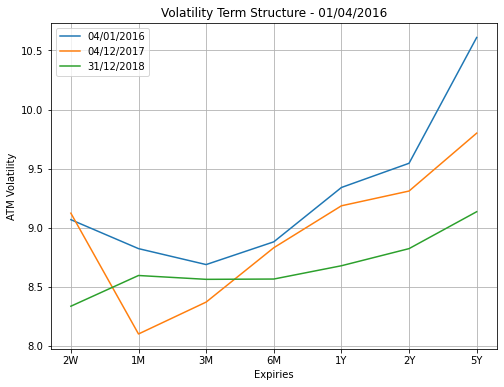

In [116]:
plt.figure(1, figsize=(8,6))

df_vol.loc['04/01/2016'].plot()
df_vol.loc['04/12/2017'].plot()
df_vol.loc['31/12/2018'].plot()
plt.xlabel('Expiries'); plt.ylabel('ATM Volatility')
plt.title('Volatility Term Structure - 01/04/2016')
plt.grid(); plt.legend(); plt.show()

## Analyze correlation between expiries

In [134]:
# Scale data for PCA analysis
scale_function = lambda x:(x-x.mean())/(x.max()-x.min())

scale_data = df_vol.apply(scale_function).dropna()
scale_data.head()

,2W,1M,3M,6M,1Y,2Y,5Y
Date,,,,,,,
10/11/2020,-0.070928,-0.103387,-0.171457,-0.239657,-0.325288,-0.360046,-0.399873
09/11/2020,-0.063049,-0.093646,-0.164189,-0.228639,-0.307486,-0.338472,-0.391377
06/11/2020,-0.060641,-0.095938,-0.147088,-0.198486,-0.270721,-0.311822,-0.376933
05/11/2020,-0.056045,-0.100379,-0.153287,-0.209503,-0.276913,-0.313091,-0.370136
04/11/2020,-0.068630,-0.104963,-0.167182,-0.217912,-0.284653,-0.322821,-0.359941


<AxesSubplot:>

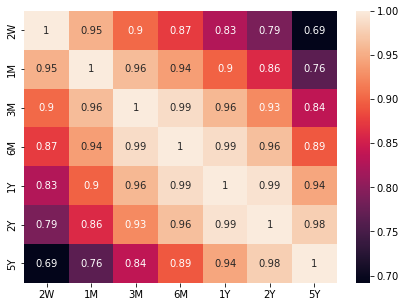

In [135]:
corr = scale_data.corr()
sns.heatmap(corr, annot=True)

In [159]:
len(symbols)

7

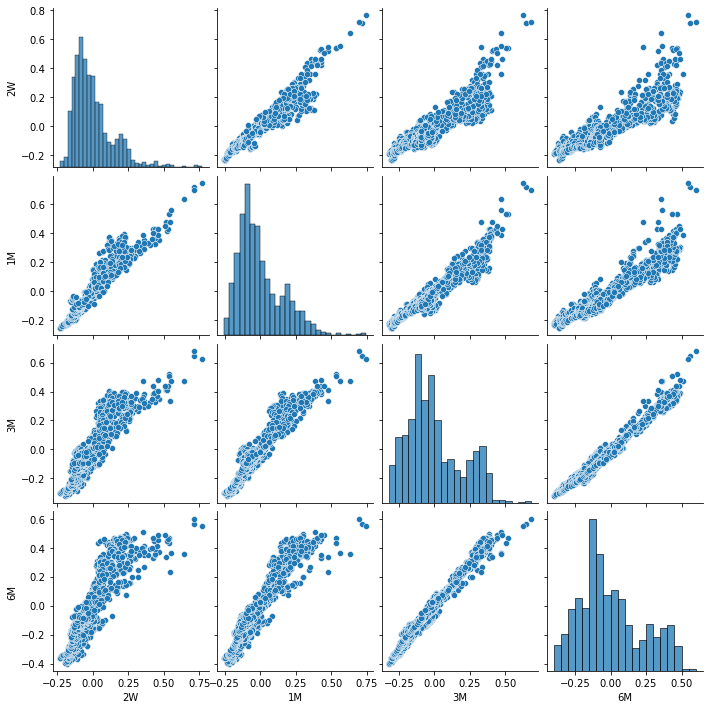

In [161]:
import seaborn as sns
sns.pairplot(scale_data[symbols[0:4]])

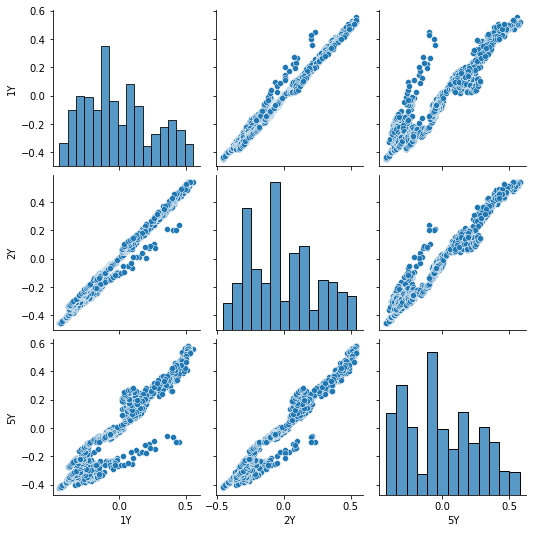

In [162]:
sns.pairplot(scale_data[symbols[4:8]])

## Apply Principle Component Analysis

In [144]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 7)
pca.fit(scale_data)

PCA(n_components=7)

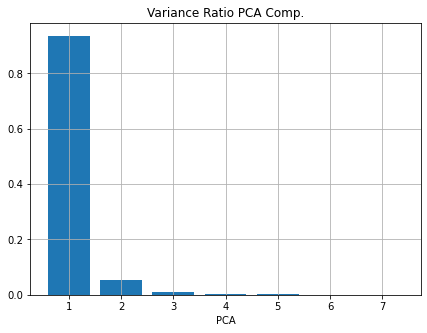

In [145]:
temp = np.linspace(1,7,7)
plt.bar(temp, pca.explained_variance_ratio_)
plt.title("Variance Ratio PCA Comp.")
plt.xlabel('PCA')
plt.grid()

In [146]:
test = PCA(n_components = 2)
test.fit(df_vol)
print(np.sum(test.explained_variance_ratio_))

0.9810335912548089


Explained variance of two components is higher than 95% so we can use n = 2

In [155]:
symbols = scale_data.columns
symbols

Index(['2W', '1M', '3M', '6M', '1Y', '2Y', '5Y'], dtype='object')

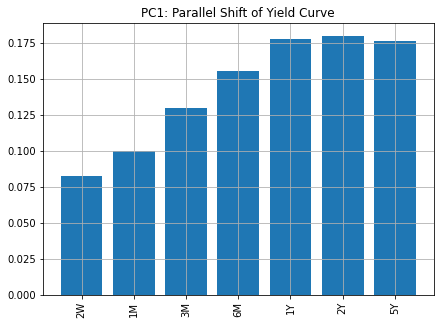

In [156]:
s1 = pca.components_[0].sum()
w1 = pca.components_[0]/np.abs(s1)
plt.bar(symbols, w1)
plt.xticks(rotation=90);
plt.title("PC1: Parallel Shift of Yield Curve")
plt.grid()

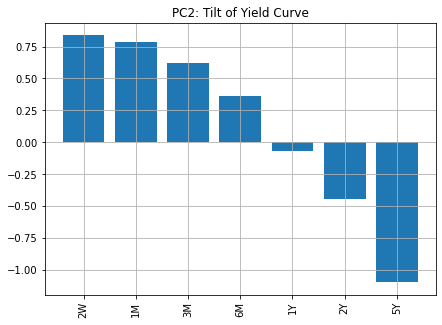

In [157]:
s1 = pca.components_[1].sum()
w1 = pca.components_[1]/np.abs(s1)
plt.bar(symbols, w1)
plt.xticks(rotation=90);
plt.title("PC2: Tilt of Yield Curve")
plt.grid()